# Welcome to Lucien Notebook! 🎉

Welcome to Lucien's interactive programming environment! Here you can:
- Write and execute code
- Create data visualizations
- Explore and create interesting content with Lucien Agent

## Working with Files in Your Directory 📁

Lucien Notebook is configured to use your working directory as the base directory for all file operations. This means you can easily access files in your project:

```python
# Read a file directly from your working directory
with open('input.txt', 'r') as f:
    content = f.read()

# Write to a file in your working directory
with open('output.txt', 'w') as f:
    f.write('Hello, Lucien!')

# List files in your working directory
import os
files = os.listdir('.')
print(files)
```

You can also use relative paths to access subdirectories:

```python
# Access files in subdirectories
with open('subfolder/data.json', 'r') as f:
    import json
    data = json.load(f)
```

> 💡 **Tip**: The notebook kernel is already configured to use your working directory as the current directory, so you can use simple relative paths without any additional setup.

Start exploring now!

In [1]:

import random
import json

# 1. 生成一个在[-1, 1]区间内的三维随机坐标
particle_position = [[random.uniform(-1, 1) for _ in range(3)]]

# 2. 定义势阱参数
# [center_x, center_y, center_z, U, a, b, c, e]
trap_parameters = [0.0, 0.0, 0.0, 40.0, 1.0, 1.0, 1.0, 1.0]

# 准备输出
output = {
    "particle_position": particle_position,
    "trap_parameters": trap_parameters
}

print(json.dumps(output))


{"particle_position": [[-0.12584488236592128, 0.9552094118614274, -0.8720196257071202]], "trap_parameters": [0.0, 0.0, 0.0, 40.0, 1.0, 1.0, 1.0, 1.0]}


In [2]:

import json

# 1. 定义模拟的基本参数
num_steps = 400
U_initial = 40.0

# 2. 定义不随时间变化的静态参数
# [center_x, center_y, center_z, ..., a, b, c, e, H]
center_x, center_y, center_z = 0.0, 0.0, 0.0
a, b, c, e = 1.0, 1.0, 1.0, 1.0
H = 0.0  # 蒸发梯度为0

# 3. 初始化一个列表来存储所有时间步的参数
all_parameters = []

# 4. 循环400步，生成每个时刻的参数列表
for i in range(num_steps):
    # 使用线性插值计算当前步的 U1 和 U2
    # U1 从 U_initial 线性变化到 U_initial / 2
    current_u1 = U_initial + (U_initial / 2 - U_initial) * (i / (num_steps - 1))
    
    # U2 从 0 线性变化到 U_initial / 2
    current_u2 = 0 + (U_initial / 2 - 0) * (i / (num_steps - 1))
    
    # 组装当前时间步的完整参数列表
    current_params = [
        center_x, center_y, center_z,
        current_u1, current_u2,
        a, b, c, e,
        H
    ]
    
    # 将当前参数列表添加到总列表中
    all_parameters.append(current_params)

# 5. 打印结果进行验证
print(f"成功生成了 {len(all_parameters)} 步的参数序列。")

# 为了不刷屏，我们只展示序列的开头和结尾
print("\n序列的第一个参数 (t=0):")
# 格式化输出，保留两位小数
print([f"{p:.2f}" for p in all_parameters[0]])

print("\n序列的第二个参数 (t=1):")
print([f"{p:.2f}" for p in all_parameters[1]])

print("\n序列的最后一个参数 (t=399):")
print([f"{p:.2f}" for p in all_parameters[-1]])

# 你可以将 all_parameters 变量用于后续的计算
# 例如，在下一步中循环调用 cross_trap_move_evaporative 工具


成功生成了 400 步的参数序列。

序列的第一个参数 (t=0):
['0.00', '0.00', '0.00', '40.00', '0.00', '1.00', '1.00', '1.00', '1.00', '0.00']

序列的第二个参数 (t=1):
['0.00', '0.00', '0.00', '39.95', '0.05', '1.00', '1.00', '1.00', '1.00', '0.00']

序列的最后一个参数 (t=399):
['0.00', '0.00', '0.00', '20.00', '20.00', '1.00', '1.00', '1.00', '1.00', '0.00']


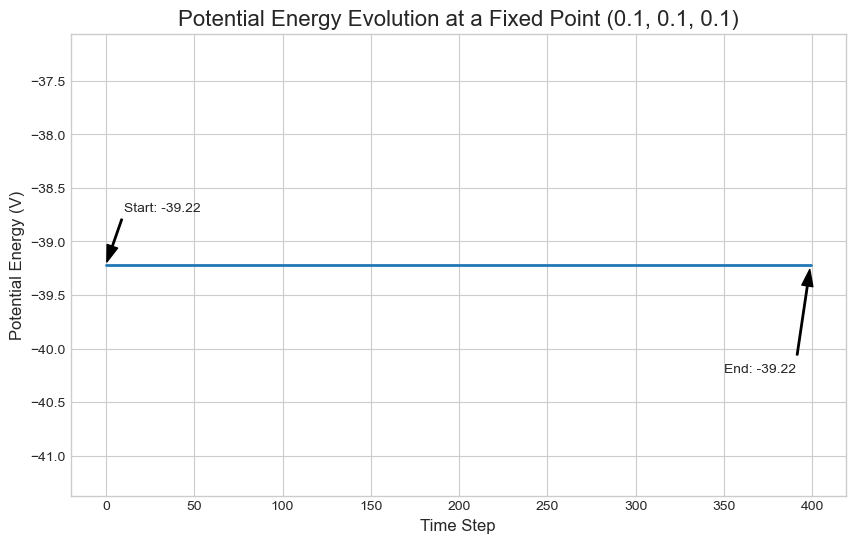

In [3]:

import matplotlib.pyplot as plt
import numpy as np

# 假设 all_parameters 变量仍然在 notebook 的内存中
# 如果不在，需要重新运行上面的单元格来生成它

# 1. 定义一个固定的粒子坐标来探测势能
# 我们不选(0,0,0)中心，因为那里的势能可能变化不明显
# 选择一个稍微偏离中心的点
particle_position = [[0.1, 0.1, 0.1]]

# 2. 定义一个函数来模拟 cross_trap_move_evaporative 的计算
# 基于物理模型，交叉阱通常是两个独立势阱的叠加
def calculate_potential(positions, parameters):
    pos = positions[0]
    x, y, z = pos[0], pos[1], pos[2]
    
    center_x, center_y, center_z, U1, U2, a, b, c, e, H = parameters
    
    # 假设交叉阱由两个正交的洛伦兹势组成
    # 第一个势阱 (主要在 x-z 平面)
    denominator1 = a * (x - center_x)**2 + c * (z - center_z)**2 + e
    potential1 = -U1 / denominator1
    
    # 第二个势阱 (主要在 y-z 平面)
    denominator2 = b * (y - center_y)**2 + c * (z - center_z)**2 + e
    potential2 = -U2 / denominator2
    
    # 蒸发势 (线性势)
    evap_potential = H * z
    
    # 总势能是三者之和
    total_potential = potential1 + potential2 + evap_potential
    return total_potential

# 3. 遍历所有参数，计算每一步的势能
potential_energies = []
for params in all_parameters:
    energy = calculate_potential(particle_position, params)
    potential_energies.append(energy)

# 4. 使用 matplotlib 绘制结果
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(potential_energies, lw=2)

# 5. 添加图表标题和标签
ax.set_title('Potential Energy Evolution at a Fixed Point (0.1, 0.1, 0.1)', fontsize=16)
ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('Potential Energy (V)', fontsize=12)
ax.grid(True)

# 标记起点和终点的值
start_energy = potential_energies[0]
end_energy = potential_energies[-1]
ax.annotate(f'Start: {start_energy:.2f}', 
            xy=(0, start_energy), 
            xytext=(10, start_energy + 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
ax.annotate(f'End: {end_energy:.2f}', 
            xy=(399, end_energy), 
            xytext=(350, end_energy - 1.0),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))


plt.show()


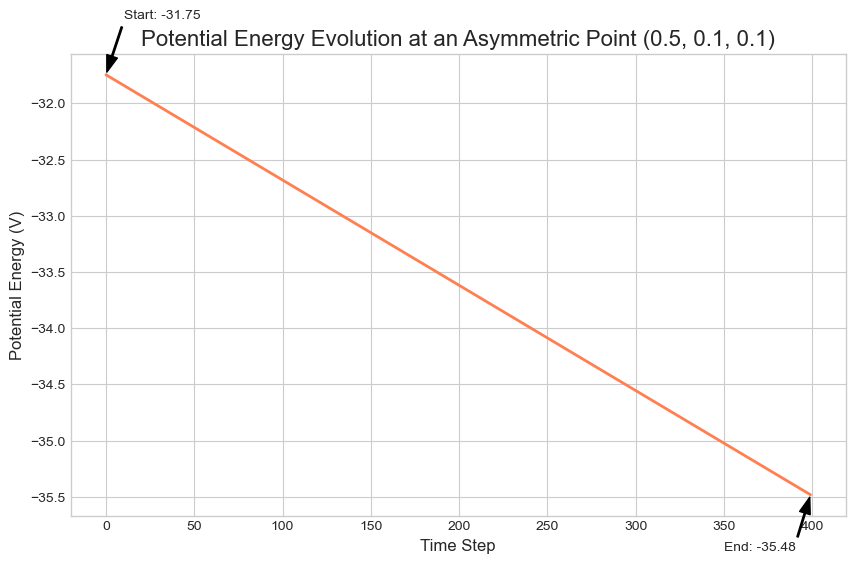

In [4]:

import matplotlib.pyplot as plt
import numpy as np

# 假设 all_parameters 变量仍然在 notebook 的内存中

# 1. 定义一个新的、不对称的粒子坐标
particle_position = [[0.5, 0.1, 0.1]]

# 2. 定义计算势能的函数 (与之前相同)
def calculate_potential(positions, parameters):
    pos = positions[0]
    x, y, z = pos[0], pos[1], pos[2]
    
    center_x, center_y, center_z, U1, U2, a, b, c, e, H = parameters
    
    denominator1 = a * (x - center_x)**2 + c * (z - center_z)**2 + e
    potential1 = -U1 / denominator1
    
    denominator2 = b * (y - center_y)**2 + c * (z - center_z)**2 + e
    potential2 = -U2 / denominator2
    
    evap_potential = H * z
    
    total_potential = potential1 + potential2 + evap_potential
    return total_potential

# 3. 遍历所有参数，重新计算每一步的势能
potential_energies = []
for params in all_parameters:
    energy = calculate_potential(particle_position, params)
    potential_energies.append(energy)

# 4. 使用 matplotlib 绘制新结果
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(potential_energies, lw=2, color='coral')

# 5. 更新图表标题和标签
ax.set_title('Potential Energy Evolution at an Asymmetric Point (0.5, 0.1, 0.1)', fontsize=16)
ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('Potential Energy (V)', fontsize=12)
ax.grid(True)

# 标记新的起点和终点的值
start_energy = potential_energies[0]
end_energy = potential_energies[-1]
ax.annotate(f'Start: {start_energy:.2f}', 
            xy=(0, start_energy), 
            xytext=(10, start_energy + 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
ax.annotate(f'End: {end_energy:.2f}', 
            xy=(399, end_energy), 
            xytext=(350, end_energy - 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))

plt.show()


Total parameter sequence generated for 700 steps.


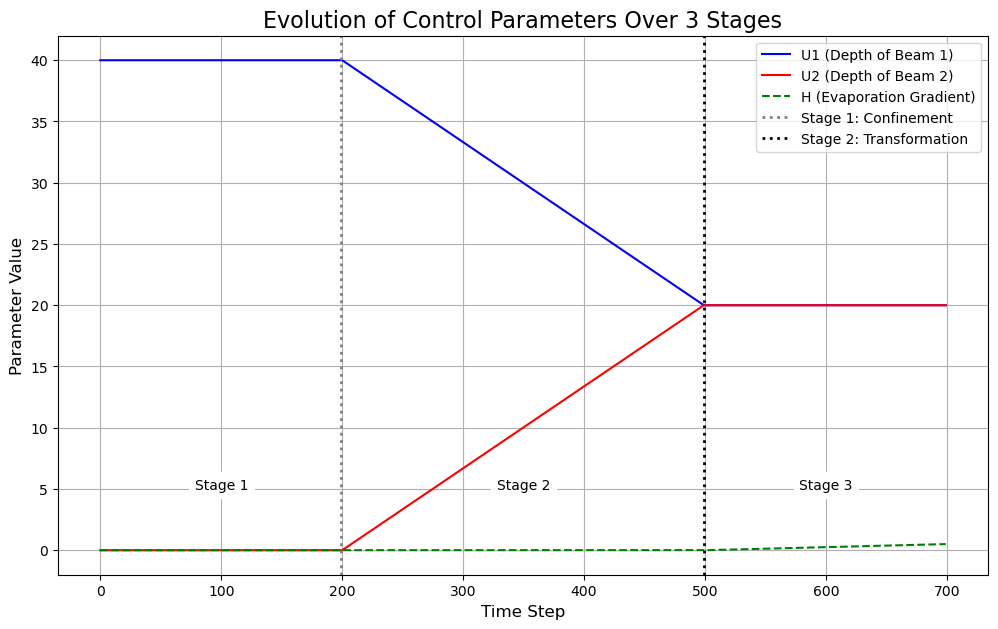

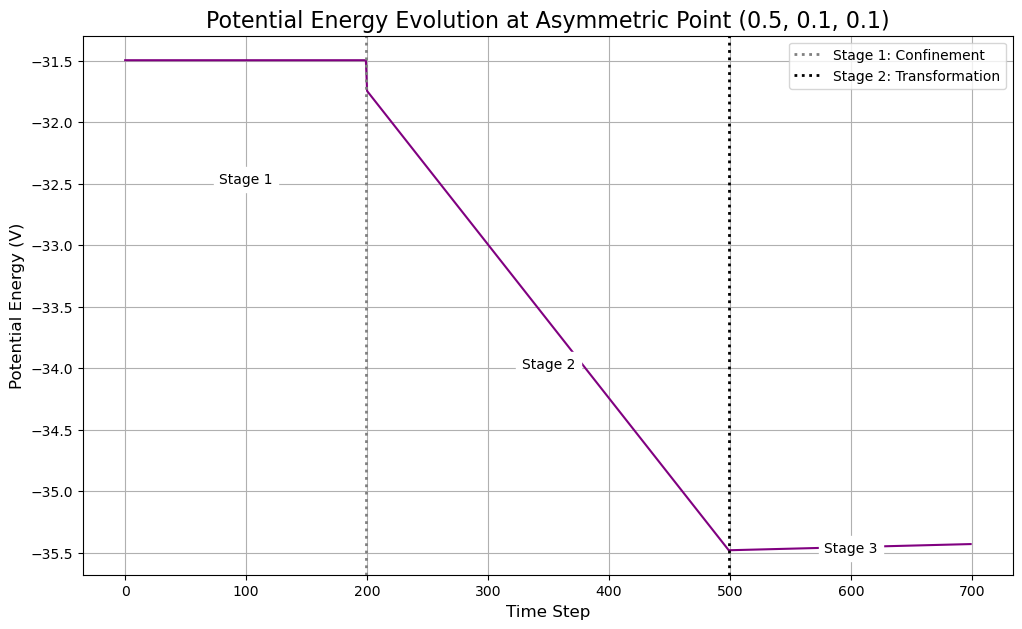

In [1]:

import matplotlib.pyplot as plt
import numpy as np

# --- Simulation Parameters ---
# Stage 1: Confinement
steps_s1 = 200
# We need to use the `trap` tool's parameter format first, which has 8 elements.
# Let's define it and then convert to the 10-element format for consistency in the plot list.
# `trap` params: [center_x, center_y, center_z, U, a, b, c, e]
params_s1_trap = [0.0, 0.0, 0.0, 40.0, 1.0, 1.0, 1.0, 1.0]
# For internal consistency in our `all_parameters` list, we'll represent it in the
# 10-element `cross_trap_move_evaporative` format, knowing that U2=0 and H=0.
# The actual tool call in a real simulation would switch from `trap` to `cross_trap_move_evaporative`.
params_s1_consistent = [0.0, 0.0, 0.0, 40.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0]


# Stage 2: Transformation
steps_s2 = 300
u1_start_s2, u1_end_s2 = 40.0, 20.0
u2_start_s2, u2_end_s2 = 0.0, 20.0

# Stage 3: Evaporative Cooling
steps_s3 = 200
h_start_s3, h_end_s3 = 0.0, 0.5 # Let's set a final gradient of 0.5

# --- Generate Parameter Sequence ---
all_parameters = []

# Stage 1: Generate static parameters
# In a real simulation, you would call the `trap` tool with `params_s1_trap` for these steps.
# Here, we store the consistent version for plotting.
params_s1_list = [params_s1_consistent for _ in range(steps_s1)]
all_parameters.extend(params_s1_list)

# Stage 2: Generate dynamic parameters for transformation
params_s2_list = []
for i in range(steps_s2):
    # Linear interpolation for U1 and U2
    current_u1 = u1_start_s2 + (u1_end_s2 - u1_start_s2) * (i / (steps_s2 - 1))
    current_u2 = u2_start_s2 + (u2_end_s2 - u2_start_s2) * (i / (steps_s2 - 1))
    
    current_params = [0.0, 0.0, 0.0, current_u1, current_u2, 1.0, 1.0, 1.0, 1.0, 0.0]
    params_s2_list.append(current_params)
all_parameters.extend(params_s2_list)

# Stage 3: Generate dynamic parameters for cooling
params_s3_list = []
final_params_s2 = all_parameters[-1]
for i in range(steps_s3):
    # Linear interpolation for H
    current_h = h_start_s3 + (h_end_s3 - h_start_s3) * (i / (steps_s3 - 1))
    
    current_params = final_params_s2[:9] + [current_h]
    params_s3_list.append(current_params)
all_parameters.extend(params_s3_list)

print(f"Total parameter sequence generated for {len(all_parameters)} steps.")

# --- Visualization ---

# 1. Plot the evolution of control parameters (U1, U2, H)
u1_values = [p[3] for p in all_parameters]
u2_values = [p[4] for p in all_parameters]
h_values = [p[9] for p in all_parameters]
time_steps = np.arange(len(all_parameters))

fig1, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot(time_steps, u1_values, label='U1 (Depth of Beam 1)', color='blue')
ax1.plot(time_steps, u2_values, label='U2 (Depth of Beam 2)', color='red')
ax1.plot(time_steps, h_values, label='H (Evaporation Gradient)', color='green', linestyle='--')

# Add vertical lines to delineate stages
ax1.axvline(x=steps_s1 - 1, color='gray', linestyle=':', lw=2, label='Stage 1: Confinement')
ax1.axvline(x=steps_s1 + steps_s2 - 1, color='black', linestyle=':', lw=2, label='Stage 2: Transformation')
ax1.text(steps_s1/2, 5, 'Stage 1', horizontalalignment='center', backgroundcolor='white')
ax1.text(steps_s1 + steps_s2/2, 5, 'Stage 2', horizontalalignment='center', backgroundcolor='white')
ax1.text(steps_s1 + steps_s2 + steps_s3/2, 5, 'Stage 3', horizontalalignment='center', backgroundcolor='white')


ax1.set_title('Evolution of Control Parameters Over 3 Stages', fontsize=16)
ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Parameter Value', fontsize=12)
ax1.legend()
ax1.grid(True)
plt.show()


# 2. Plot the potential energy at the asymmetric point
particle_position = [[0.5, 0.1, 0.1]]

def calculate_potential(positions, parameters):
    pos = positions[0]
    x, y, z = pos[0], pos[1], pos[2]
    
    # Adapt calculation based on which stage we are in (which tool would be used)
    if len(parameters) == 8: # Corresponds to `trap`
        center_x, center_y, center_z, U, a, b, c, e = parameters
        denominator = a * (x - center_x)**2 + b * (y - center_y)**2 + c * (z - center_z)**2 + e
        return -U / denominator
    else: # Corresponds to `cross_trap_move_evaporative`
        center_x, center_y, center_z, U1, U2, a, b, c, e, H = parameters
        # As before, assuming two orthogonal Lorentz potentials
        denominator1 = a * (x - center_x)**2 + c * (z - center_z)**2 + e
        potential1 = -U1 / denominator1
        denominator2 = b * (y - center_y)**2 + c * (z - center_z)**2 + e
        potential2 = -U2 / denominator2
        evap_potential = H * z
        return potential1 + potential2 + evap_potential

# We need to calculate potentials based on the correct tool for each stage
potential_energies = []
# Stage 1
for _ in range(steps_s1):
    potential_energies.append(calculate_potential(particle_position, params_s1_trap))
# Stage 2 & 3
for params in all_parameters[steps_s1:]:
    potential_energies.append(calculate_potential(particle_position, params))


fig2, ax2 = plt.subplots(figsize=(12, 7))
ax2.plot(time_steps, potential_energies, color='purple')

# Add vertical lines to delineate stages
ax2.axvline(x=steps_s1 - 1, color='gray', linestyle=':', lw=2, label='Stage 1: Confinement')
ax2.axvline(x=steps_s1 + steps_s2 - 1, color='black', linestyle=':', lw=2, label='Stage 2: Transformation')
ax2.text(steps_s1/2, -32.5, 'Stage 1', horizontalalignment='center', backgroundcolor='white')
ax2.text(steps_s1 + steps_s2/2, -34, 'Stage 2', horizontalalignment='center', backgroundcolor='white')
ax2.text(steps_s1 + steps_s2 + steps_s3/2, -35.5, 'Stage 3', horizontalalignment='center', backgroundcolor='white')


ax2.set_title('Potential Energy Evolution at Asymmetric Point (0.5, 0.1, 0.1)', fontsize=16)
ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Potential Energy (V)', fontsize=12)
ax2.legend()
ax2.grid(True)
plt.show()
